In [98]:
import warnings
import time
warnings.filterwarnings("ignore")
# Import utilities
#import diabetes_utils

from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier,RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, RocCurveDisplay, brier_score_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.metrics import classification_report_imbalanced
 

#from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss

In [147]:
class dataUtils():
    
    randomState = 42

    def __init__(self):
        pass
        
    def getData(self, url='Datasets/diabetes_dataset.csv'):
    
        self.url = url
        self.df = pd.read_csv(self.url)
        return self.df

    def cleanData(self, url='Datasets/diabetes_binary_health_indicators_BRFSS2015.csv'):
            
        #Drop duplicates
        print('Dropping duplicates...\n')
        self.df.drop_duplicates(inplace=True)
        time.sleep(1)

        #Change all column names to lower case
        print('Converting to lower case columns and data...')
        self.df.columns = self.df.columns.str.replace('Diabetes_binary','diabetes').str.lower()

        #This next for loop doesn't get executed because there are no "object" type columns
        for col in self.df.select_dtypes(object).columns:
            self.df[col] = self.df[col].str.lower().str.replace(' ', '_')
        
        time.sleep(1)

        return self.df

    def splitData(self):
        
        target = self.df.diabetes
        data = self.df.drop(columns=['diabetes'])
        self.dfTrainFull, self.dfTest, self.yTrainFull, self.yTest = train_test_split(data, target, test_size=0.2, random_state=self.randomState)
        self.dfTrain, self.dfVal, self.yTrain, self.yVal = train_test_split(self.dfTrainFull, self.yTrainFull, test_size=0.25, random_state=self.randomState)
        
        print(  f'Dataset has been split in: Training set with {len(self.yTrain)} samples, '
                f'Validation set with {len(self.yVal)} samples and Test set with {len(self.yTest)} samples')

        return self.dfTrainFull, self.yTrainFull, self.dfTrain, self.yTrain, self.dfVal, self.yVal, self.dfTest, self.yTest

    def getMeasures(self, model):

        res = {}
        
        measureType = ['auc']
        
        for measure in measureType:

            yTestpredProb = model.predict_proba(self.dfTest)[:,1]
            yTestpred = model.predict(self.dfTest)
            auc = round(roc_auc_score(self.yTest, yTestpredProb),3)
            f1Score = round(f1_score(yTest, yTestpred, average='weighted'),3)
            print(f'Weighted f1-score: {f1Score} --- auc: {auc}\n')
            
            res[measure] = auc

            #for key,value in res.items():
            #    print(f'Test {key}: {value}\n')

            print(classification_report(self.yTest, yTestpred))
            #print(classification_report_imbalanced(self.yTest, yTestpred))
            
            fig, ax = plt.subplots(figsize=(6, 4))
            fpr, tpr, _ = roc_curve(self.yTest.values, yTestpredProb)
            roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
            #fpr2, tpr2, _ = roc_curve(yVal, targetRand)
            #roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax)
            plt.text(0.4,0.5,f'auc = {auc}', size=14, fontweight='semibold')
            plt.text(0.4,0.4,f'Weighted f1  = {f1Score}', size=14, fontweight='semibold')
            plt.show()
            
            
            plt.show()
            
            return res, yTestpred, yTestpredProb

        
    def reload(self, module):
        importlib.reload(module)

### Load binary unbalanced data

In [148]:
utils = dataUtils()
df = utils.getData()
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


### EDA

#### Preparing and cleaning data

In [149]:
df = utils.cleanData(df)
df

Dropping duplicates...

Converting to lower case columns and data...


,diabetes,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdiseaseorattack,physactivity,fruits,...,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,1,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


#### Checking Correlations

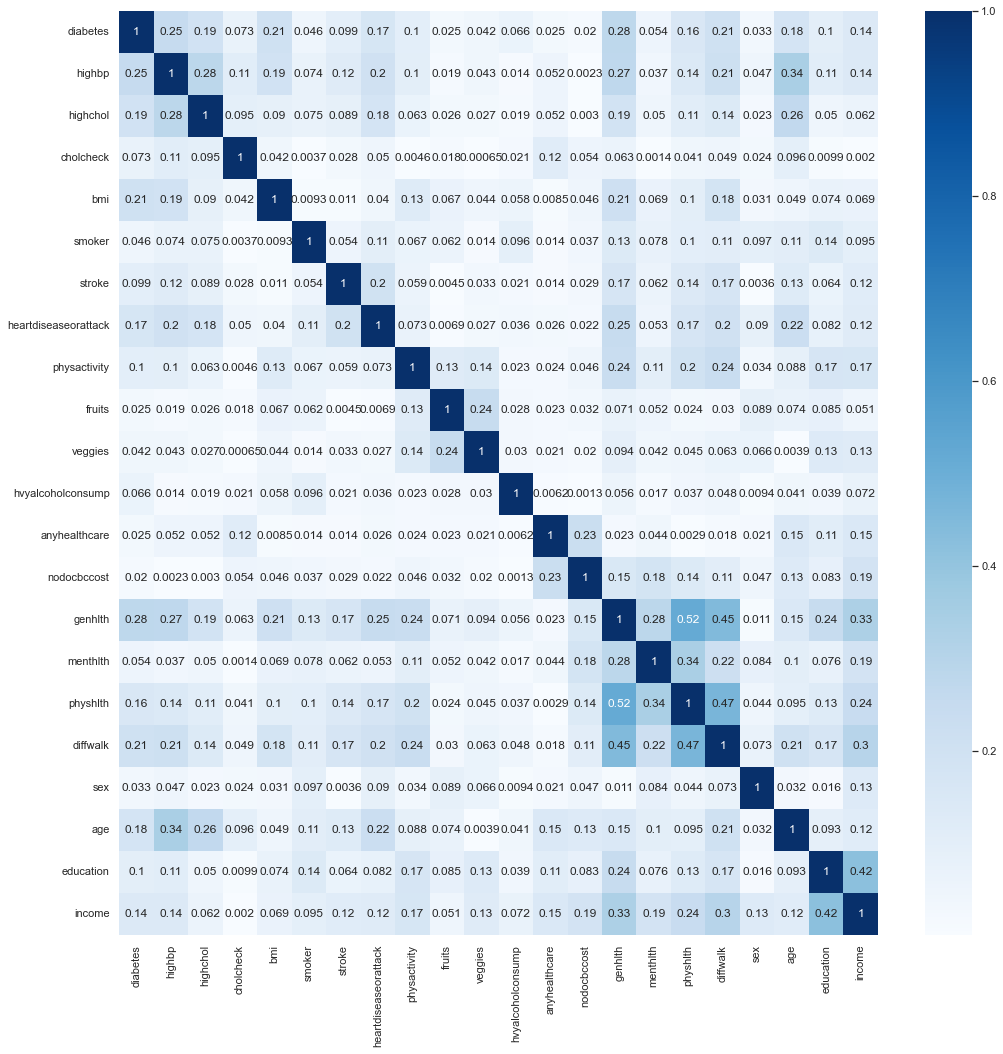

In [5]:
sns.set_theme()
corr_matrix = df.corr().abs()
plt.figure(figsize=(17,17))

_ = sns.heatmap(corr_matrix, cmap="Blues", annot=True)

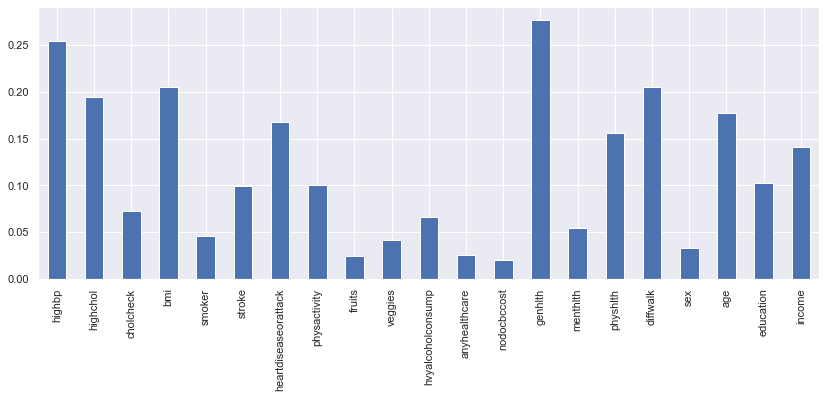

In [6]:
#corr_matrix.diabetes.sort_values(ascending=False).hist()
sns.set_theme()
dfMatrix = df.drop(columns='diabetes')
corr_matrix = dfMatrix.corrwith(df.diabetes).abs()
plt.figure(figsize=(14,5))
_ = corr_matrix.plot(kind='bar', grid=True)
_ = plt.show()    

In [7]:
corr_matrix.sort_values(ascending=False)

genhlth                 0.276940
highbp                  0.254318
diffwalk                0.205302
bmi                     0.205086
highchol                0.194944
age                     0.177263
heartdiseaseorattack    0.168213
physhlth                0.156211
income                  0.140659
education               0.102686
physactivity            0.100404
stroke                  0.099193
cholcheck               0.072523
hvyalcoholconsump       0.065950
menthlth                0.054153
smoker                  0.045504
veggies                 0.041734
sex                     0.032724
anyhealthcare           0.025331
fruits                  0.024805
nodocbccost             0.020048
dtype: float64

In [153]:
#newdf = df.copy()
newdf = df.drop(columns=['nodocbccost', 'fruits', 'anyhealthcare', 'sex', 'veggies', 'smoker', 'menthlth','physhlth'])

#### The target value is heavily imbalanced.  No Diabetes- 194377, Diabetes- 35097.

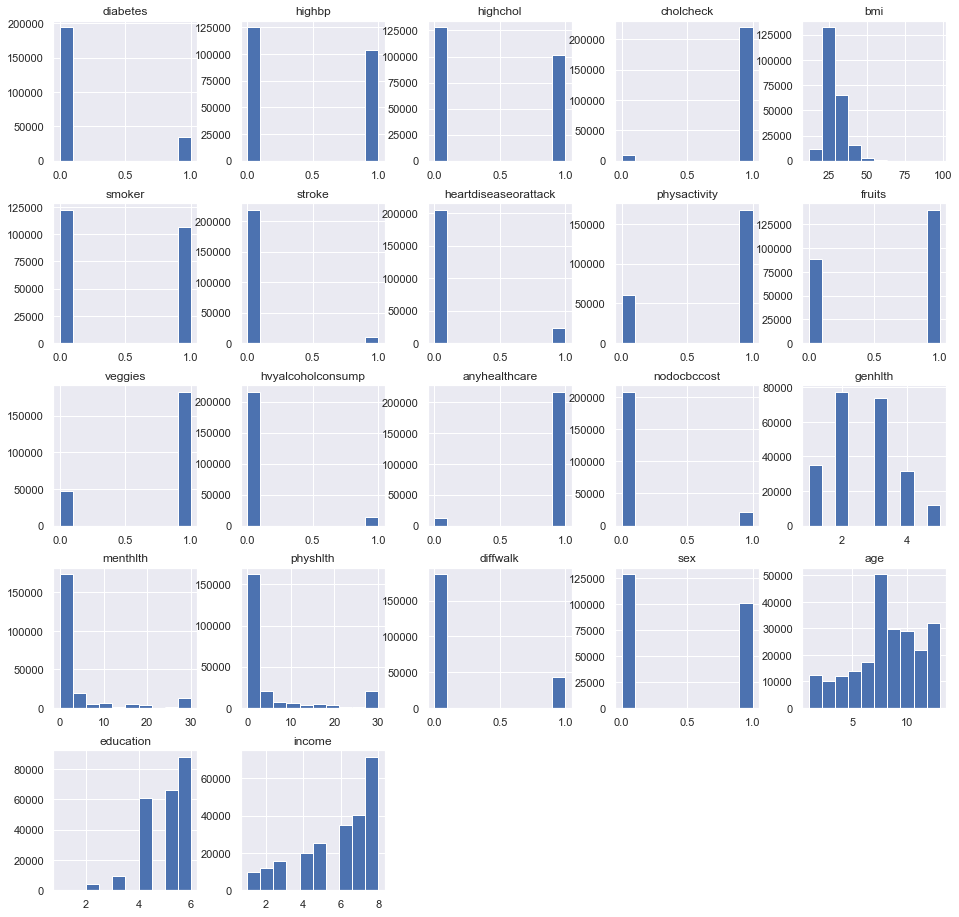

In [9]:
_= df.hist(figsize=(16,16))

In [154]:
dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest = utils.splitData()

Dataset has been split in: Training set with 137684 samples, Validation set with 45895 samples and Test set with 45895 samples


### Preprocessing

In [33]:
categoricalCols = ['highbp', 'highchol', 'cholcheck','smoker',
       'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies',
       'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'genhlth','diffwalk', 'sex', 'education']

numericalCols = ['bmi', 'menthlth', 'physhlth', 'income']

In [34]:
#dfTrain.income = np.log1p(dfTrain.income)

In [35]:
# creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

# Transforming the data
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    #('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")
    #('one-hot-encoder', catPreprocessor, categoricalCols),('standard_scaler', numPreprocessor, numericalCols)])
    ], remainder="passthrough")


In [36]:
randomState = 42

### DecisionTreeClassifier

In [ ]:
%%time

# inner cross-validation(for Hyperparameter tuning)
innerCV = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)
# inner cross-validation(for testing the tunned model)
outerCV = StratifiedKFold(n_splits=3, shuffle=True, random_state=randomState)

parameters = ['max_depth', 'max_features', 'max_leaf_nodes']
scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}

# Model
model = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced', random_state = randomState))])

# Gridsearch params
param_grid = {
    'classifier__max_depth': (1,3,5,7,10),
    'classifier__max_leaf_nodes': (1, 5,10,15,20),
    'classifier__max_features': (1,3,5,7,10)
}

# Gridsearch
model_grid_search = GridSearchCV(model,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 #scoring="f1_weighted",
                                 #scoring="neg_brier_score",
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 refit=False)

model_grid_search.fit(dfTrainFull, yTrainFull)

In [16]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)

#cv_results
res = cv_results[[
    "param_classifier__max_depth",
    'param_classifier__max_leaf_nodes',
    "param_classifier__max_features",
    "mean_train_auc",
    "std_train_auc",
    "rank_test_auc",
    "mean_train_f1_weighted",
    "std_train_f1_weighted",
    "rank_test_f1_weighted"
]]

res.sort_values(by=['rank_test_f1_weighted', 'rank_test_auc']).head(10)

,param_classifier__max_depth,param_classifier__max_leaf_nodes,param_classifier__max_features,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted
62,5,10,5,0.744473,0.001966,34,0.757010,0.002557,1
87,7,10,5,0.744473,0.001966,34,0.757010,0.002557,1
112,10,10,5,0.744473,0.001966,34,0.757010,0.002557,1
88,7,15,5,0.756175,0.002927,22,0.747676,0.018926,4
113,10,15,5,0.756175,0.002927,22,0.747676,0.018926,4
37,3,10,5,0.739860,0.000453,41,0.741973,0.000547,6
38,3,15,5,0.739860,0.000453,41,0.741973,0.000547,6
39,3,20,5,0.739860,0.000453,41,0.741973,0.000547,6
63,5,15,5,0.754428,0.002047,27,0.739337,0.020493,9
114,10,20,5,0.761788,0.002346,17,0.738182,0.011587,10


#### Selecting best parameters
We will choose max_depth=5, max_features=10 and max_leaf_nodes=10. reaching a compromise between F1 Score and AUC.

In [63]:
%%time

model = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced',
                                                        random_state = randomState,
                                                        max_depth=7,
                                                        max_features=15,
                                                        max_leaf_nodes=5))])

model.fit(dfTrainFull, yTrainFull)

#print(classification_report(yTest, model.predict(dfTest)))
#print(classification_report_imbalanced(yTest, model.predict(dfTest)))

Wall time: 149 ms


Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=7,
                                        max_features=15, max_leaf_nodes=5,
                                        random_state=42))])

#### Nested CrossValidation

In [64]:
cv_results = cross_validate(
    model, dfTrainFull, yTrainFull, cv=outerCV, n_jobs=-1, return_estimator=True
)

cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Scores hyperparameters tuning:"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}\n"
)

for i,j in enumerate(cv_results["estimator"]):
    
    params = []
    for param in parameters:
        params.append(f'{param}={j.steps[0][1].get_params()[param]}')
    print(f'Best hyperparameters for fold {i}, {", ".join(params)}')


Scores hyperparameters tuning:0.705 ± 0.062

Best hyperparameters for fold 0, max_depth=7, max_features=15, max_leaf_nodes=5
Best hyperparameters for fold 1, max_depth=7, max_features=15, max_leaf_nodes=5
Best hyperparameters for fold 2, max_depth=7, max_features=15, max_leaf_nodes=5


#### Getting error values and curves

Weighted f1-score: 0.772 --- auc: 0.742

              precision    recall  f1-score   support

           0       0.91      0.77      0.84     38813
           1       0.32      0.61      0.42      7082

    accuracy                           0.74     45895
   macro avg       0.62      0.69      0.63     45895
weighted avg       0.82      0.74      0.77     45895



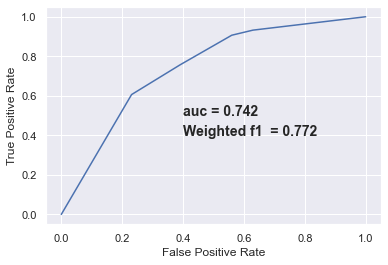

In [152]:
_ = utils.getMeasures(model)

### Logistic Regression

In [ ]:
steps = [ ('scale', StandardScaler()), ('model', LogisticRegression(max_iter=1000,class_weight='balanced'))]
#StandardScaler().fit(dfTrainFull)
#pipeline = make_pipeline(StandardScaler(), LogisticRegression())
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
scores = pd.DataFrame.from_dict( cross_validate(pipeline, dfTrain, yTrain, cv=cv,
                         scoring=('f1', 'f1_weighted',  'recall' , 'precision', 'accuracy', 'roc_auc'),
                         return_train_score=True))
                                
scores

In [ ]:
scoresx = scores.mean(axis=0)     
scoresx

In [ ]:
model = Pipeline([("classifier", LogisticRegression(max_iter=1000,class_weight='balanced'))])

param_grid = {
    'classifier__C': (1e-3, 1e-2, 0.05, 0.1, 0.05, 1),
    #'classifier__max_leaf_nodes': (1, 5,10,15,20),
    #'classifier__max_features': (1,3,5,7,10)
}
scoring = {"AUC": "roc_auc", "f1_weighted": "f1_weighted"}

cv = StratifiedKFold(n_splits=3)
model_grid_search = GridSearchCV(model,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 #scoring="f1_weighted",
                                 #scoring="f1_weighted",
                                 n_jobs=2,
                                 cv=cv,
                                 return_train_score=True,
                                 refit=False)
model_grid_search.fit(dfTrain, yTrain)

In [ ]:
print(model_grid_search.cv_results_.keys())

cv_results = pd.DataFrame(model_grid_search.cv_results_)
#cv_results
res = cv_results[[
    "param_classifier__C",
    #"mean_test_score",
    #'std_test_score',
    #'rank_test_score'
    "mean_train_AUC",
    "std_train_AUC",
    "rank_test_AUC",
    "mean_train_f1_weighted",
    "std_train_f1_weighted",
    "rank_test_f1_weighted"
]]

In [ ]:
res.sort_values(by=['rank_test_f1_weighted',"rank_test_AUC"]).head(10)

In [ ]:
#display = PrecisionRecallDisplay.from_estimator(
#    model_grid_search, dfVal, yVal, name="Validation", 
#)
#_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
cv = StratifiedKFold(n_splits=3)
model_grid_search = GridSearchCV(model,
                                 param_grid=param_grid,
                                 #scoring=scoring,
                                 scoring="roc_auc",
                                 #scoring="f1_weighted",
                                 n_jobs=2,
                                 cv=cv,
                                 return_train_score=True,
                                 refit=True)
model_grid_search.fit(dfTrainFull, yTrainFull)

In [ ]:
yValPredProba = model_grid_search.predict_proba(dfVal)[:,1]
yValPred = model_grid_search.predict(dfVal)
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=model_grid_search.predict_proba(dfTest)[:,1]
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPredProba = model_grid_search.predict_proba(dfTrain)[:,1]
yTrainPred = model_grid_search.predict(dfTrain)
auc = roc_auc_score(yTrain, yTrainPredProba)
print(f'Train AUC: {auc}\n')

print(classification_report(yVal, yValPred))
print(classification_report_imbalanced(yVal, model_grid_search.predict(dfVal)))

### Random Forest

In [ ]:
model = make_pipeline(RandomForestClassifier(n_estimators=10,
                                             random_state=1,
                                             max_depth=6,
                                             max_features=7,
                                             class_weight='balanced'))
model.fit(dfTrain, yTrain)

In [ ]:
#yValPred = RF.predict_proba(dfVal)[:,1]

#roc_auc_score(yVal, yValPred)

yValPredProba = model.predict_proba(dfVal)[:,1]
yValPred = model.predict(dfVal)
print(f'Val prediction: {yValPred}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test prediction: {yTestpred}')
print(f'Test RMSE: {mean_squared_error(yTest, yTestpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPredProba = model.predict_proba(dfTrain)[:,1]
yTrainPred = model.predict(dfTrain)
print(f'Train prediction: {yTrainPred}')
print(f'Train RMSE: {mean_squared_error(yTrain, yTrainPredProba,squared=False)}')
print(f'Train AUC: {auc}')



print(classification_report(yVal, model.predict(dfVal)))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

### AdaBoostClassifier

In [ ]:
model = make_pipeline(StandardScaler(), AdaBoostClassifier())
model.fit(dfTrain, yTrain)

In [ ]:
yValPredProba = model.predict_proba(dfVal)[:,1]
yValPred = model.predict(dfVal)
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPredProba = model.predict_proba(dfTrain)[:,1]
yTrainPred = model.predict(dfTrain)
print(f'Train AUC: {auc}\n')



print(classification_report(yVal, model.predict(dfVal), ))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
fpr, tpr, _ = roc_curve(yVal.values, yValPredProba)
roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
#fpr2, tpr2, _ = roc_curve(yVal, targetRand)
#roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax)

plt.show()

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    model, dfVal, yVal, name="Validation", 
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### XGBoost

In [ ]:
dTrain = xgb.DMatrix(dfTrain, yTrain)#, enable_categorical=True)
dVal = xgb.DMatrix(dfVal, yVal)#, enable_categorical=True)
dTest = xgb.DMatrix(dfTest, yTest)#, enable_categorical=True)
xgbParams = {
'eta': 0.05,
'max_depth': 10,
'min_child_weight': 1,

'objective': 'binary:logistic',
'nthreads': 8,

'seed': 1,
'verbosity': 1,
}

model = xgb.train(xgbParams, dTrain, num_boost_round=10, )

yValPred = model.predict(dVal)

print(f'Val AUC: {roc_auc_score(yVal,yValPred)}')

yTestpred = model.predict(dTest)
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPred = model.predict(dTrain)
print(f'Train AUC: {roc_auc_score(yTrain,yTrainPred)}')

print(classification_report(yVal, (yValPred > 0.5).astype(int)))
print(classification_report_imbalanced(yVal, (yValPred > 0.5).astype(int)))

In [ ]:
cm = confusion_matrix(yVal, (yValPred > 0.5).astype(int))
cmprob = np.round(100 * cm / len(yVal), 1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1']).plot()
cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['0', '1']).plot()

In [ ]:
# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_validate (model, dfTrain, yTrain, scoring=['roc_auc','f1_weighted'], cv=cv, n_jobs=-1)

In [ ]:
scores

In [ ]:
# summarize performance
print('Mean ROC AUC: %.5f' % scores['test_roc_auc'].mean())

In [ ]:
score = pd.DataFrame(scores)
score

In [ ]:
scoresMean = score.mean(axis=0)     
scoresStd = score.std(axis=0)    
for k, i,j in list(zip(score.columns.values,scoresMean, scoresStd)):
    print(f'{k} - {i} +/- {j}')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
fpr, tpr, _ = roc_curve(yVal.values, yValPredProba)
roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
#fpr2, tpr2, _ = roc_curve(yVal, targetRand)
#roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax)

plt.show()

In [ ]:
%%time
model = Pipeline([("classifier", XGBClassifier(n_estimators=10, n_jobs=-1))])

param_grid = {
    'classifier__max_depth' : (5,10,15,20,25,40),
    'classifier__learning_rate' : (0.01, 0.05, 0.1, 0.5, 0.8),
    'classifier__min_child_weight' : (1,10,20,30,50),
    #'classifier__max_leaves': (5,10,20,30)
}
scoring = {"AUC": "roc_auc", "f1_weighted": "f1_weighted"}

cv = StratifiedKFold(n_splits=3)
model_grid_search = GridSearchCV(model,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=cv,
                                 return_train_score=True,
                                 refit=False)
model_grid_search.fit(dfTrainFull, yTrainFull)

In [ ]:
%%time
cv_results = pd.DataFrame(model_grid_search.cv_results_)
res = cv_results[[
    "param_classifier__max_depth",
    "param_classifier__learning_rate",
    "param_classifier__min_child_weight",
    
    #"mean_test_score",
    #'std_test_score',
    #'rank_test_score'
    "mean_train_AUC",
    "std_train_AUC",
    "rank_test_AUC",
    "mean_train_f1_weighted",
    "std_train_f1_weighted",
    "rank_test_f1_weighted"
]]

In [ ]:
%%time
res.sort_values(by=['rank_test_f1_weighted','rank_test_AUC']).head(20)

In [ ]:
%%time
model = XGBClassifier(n_estimators=10, n_jobs=-1, max_depth=40, learning_rate=0.5, min_child_weight=30)

scoring = {"AUC": "roc_auc", "f1_weighted": "f1_weighted"}

model.fit(dfTrainFull, yTrainFull)


In [ ]:
%time
yTestpred = model.predict(dfTest)
yTestpredProb = model.predict_proba(dfTest)[:,1]
print(f'Test AUC: {roc_auc_score(yTest, yTestpredProb)}')
print(classification_report(yTest, model.predict(dfTest)))
print(classification_report_imbalanced(yTest, model.predict(dfTest)))


In [ ]:
%time
cv = StratifiedKFold()
cv_results = cross_validate(
    model_grid_search, dfTrainFull, yTrainFull, cv=cv, n_jobs=-1, return_estimator=True
)

cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}"
)

for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(dfTrain, yTrain)

In [ ]:
yValPredProba = model.predict_proba(dfVal)[:,1]
yValPred = model.predict(dfVal)
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPredProba = model.predict_proba(dfTrain)[:,1]
yTrainPred = model.predict(dfTrain)
print(f'Train AUC: {auc}')

print(classification_report(yVal, model.predict(dfVal), ))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

In [ ]:
for p in model.get_params():
    print(p)

In [ ]:
model = Pipeline([("classifier", KNeighborsClassifier())])
param_grid = {
    'classifier__n_neighbors': (7,10,12,15) }
scoring = {"AUC": "roc_auc"}#, "f1_weighted": "f1_weighted"}

cv = StratifiedKFold(n_splits=3)
model_grid_search = GridSearchCV(model,
                                 param_grid=param_grid,
                                 #scoring=scoring,
                                 #scoring="f1_weighted",
                                 scoring="roc_auc",
                                 n_jobs=2,
                                 cv=cv,
                                 return_train_score=True,)
                                 #refit=False)
model_grid_search.fit(dfTrain, yTrain)

In [ ]:
print(model_grid_search.cv_results_.keys())

cv_results = pd.DataFrame(model_grid_search.cv_results_)
#cv_results
res = cv_results[[
    "param_classifier__n_neighbors",
    "mean_test_score",
    'std_test_score',
    'rank_test_score'
    #"mean_train_AUC", 
    #"std_train_AUC",
    #"rank_test_AUC",
    #"mean_train_f1_weighted",
    #"std_train_f1_weighted",
    #"rank_test_f1_weighted"
]]

res.sort_values(by=['rank_test_score']).head(10)

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    model_grid_search, dfVal, yVal, name="Validation", 
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
model = Pipeline([("classifier", KNeighborsClassifier())])
param_grid = {
    'classifier__n_neighbors': (3, 5,7,10,12) }
scoring = {"AUC": "roc_auc", "f1_weighted": "f1_weighted"}

cv = StratifiedKFold(n_splits=3)
model_grid_search = GridSearchCV(model,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 #scoring="f1_weighted",
                                 #scoring="roc_auc",
                                 n_jobs=2,
                                 cv=cv,
                                 return_train_score=True,
                                 refit=False)
model_grid_search.fit(dfTrainFull, yTrainFull)

In [ ]:
print(model_grid_search.cv_results_.keys())

cv_results = pd.DataFrame(model_grid_search.cv_results_)
#cv_results
res = cv_results[[
    "param_classifier__n_neighbors",
    #"mean_test_score",
    #'std_test_score',
    #'rank_test_score'
    "mean_train_AUC", 
    "std_train_AUC",
    "rank_test_AUC",
    "mean_train_f1_weighted",
    "std_train_f1_weighted",
    "rank_test_f1_weighted"
]]

res.sort_values(by=['rank_test_AUC','rank_test_f1_weighted']).head(10)

In [ ]:
model = Pipeline([("classifier", KNeighborsClassifier(n_neighbors=7))])
scoring = {"AUC": "roc_auc", "f1_weighted": "f1_weighted"}
cv = StratifiedKFold(n_splits=3)
#model_grid_search = cr(model,
#                                  param_grid=param_grid,
#                                 scoring=scoring,
#                                 #scoring="f1_weighted",
#                                 #scoring="roc_auc",
#                                 n_jobs=2,
#                                 cv=cv,
#                                 return_train_score=True,
#                                 refit=False)
#model_grid_search.fit(dfTrainFull, yTrainFull)


cv = StratifiedKFold(n_splits=3)
cv_results = cross_validate(model, dfTrainFull, yTrainFull,cv=cv,
                            scoring=['roc_auc', 'average_precision',
                                     'recall','f1_weighted'])
cv_results = pd.DataFrame(cv_results)
cv_results

In [ ]:
scoresMean = cv_results.mean(axis=0)     
scoresStd = cv_results.std(axis=0)    
for k, i,j in list(zip(cv_results.columns.values,scoresMean, scoresStd)):
    print(f'{k} - {i} +/- {j}')

In [ ]:


fig, ax = plt.subplots(figsize=(6, 4))
fpr, tpr, _ = roc_curve(yVal.values, yValPredProba)
roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
#fpr2, tpr2, _ = roc_curve(yVal, targetRand)
#roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax)

plt.show()

In [ ]:
importlib.reload(diabetes_utils)